<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto tem o intuito de studar Modelos de Séries Temporais para previsão de informações sobre o Covid19 no Brasil. </i>       
</p>  

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>  Este projeto tem o intuito de studar Modelos de Séries Temporais para previsão de informações sobre o Covid19 no Brasil.


</i> 
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> 
</i> 
</p>  


https://www.kaggle.com/datasets/unanimad/corona-virus-brazil?select=brazil_covid19_cities.csv

https://www.kaggle.com/code/mauriciofigueiredo/an-lise-e-previs-o-de-s-ries-temporais-covid


# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [31]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import geopandas as gpd
import builtins as builtins
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, Row, functions as F 
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.diagnostic import lilliefors

# Bibliotecas de Manipulação de Tempo
import time
import datetime

# Bibiliotecas de Seleção de Modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer 
from sklearn.feature_selection import RFE, VarianceThreshold
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder, BinaryEncoder
import category_encoders as ce 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

# Bibliotecas de Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# Spark Session
spark = SparkSession.builder.getOrCreate()

# <font color='red' style='font-size: 40px;'> Funções </font>
<hr style='border: 2px solid red;'>

In [2]:
def plota_temporal(df, titulo, x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(df, color='#1FB3E5', linewidth=2)
    plt.scatter(df.index, df, color='#1FB3E5', s=40)
    plt.title(f"{titulo}", fontsize=14)  # Define o título do gráfico e o tamanho da fonte
    plt.xlabel(f"{x}", fontsize=12)  # Define o rótulo do eixo x e o tamanho da fonte
    plt.ylabel(f"{y}", fontsize=12)  # Define o rótulo do eixo y e o tamanho da fonte
    plt.xticks(df.index, fontsize=10)  # Define o tamanho da fonte dos valores no eixo x
    plt.yticks(fontsize=10)  # Define o tamanho da fonte dos valores no eixo y
    plt.grid(True, linestyle=':', alpha=0.5)  # Adiciona linhas de grade
    plt.tight_layout()  # Ajusta automaticamente a posição dos elementos do gráfico
    plt.show()  # Exibe o gráfico

In [3]:
def ano_mes_dia(df):

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day


In [4]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]
    return x, y

In [5]:
def separa_treino_teste_temporal(data, data_teste, dados):
    dados.sort_values(by = data, ascending = True, inplace = True)
    df_train = dados.loc[dados[data] < data_teste]
    df_test = dados.loc[dados[data] >= data_teste]

    return df_train, df_test

In [6]:
def discretiza_variavel(df, variavel_quant, variavel_qualit, bins, labels, right):
    df[variavel_qualit] = pd.cut(
        df[variavel_quant], 
        bins= bins, 
        labels= labels, 
        right = right
    )
    df.drop(variavel_quant, axis = 1, inplace = True)

In [7]:
def metricas(regressor, target, y_train, y_predict_train, y_test, y_predict_test, coeficiente_det_train, coeficiente_det_test):
    y_test[target].fillna(y_train[target].median(), inplace = True)

    mae_train = mean_absolute_error(y_predict_train, y_train)
    mse_train = mean_squared_error(y_predict_train, y_train)
    mape_train = mean_absolute_percentage_error(y_predict_train, y_train)
    metricas_treino = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_train, 'Erro_Medio_Absoluto':mae_train, 'Erro_Quadratico_Medio':mse_train, 'Media_Percentual_Absoluta_Erro':mape_train, 'Etapa':'treino', 'Regressor':regressor}, index = np.arange(1, 2))


    mae_test = mean_absolute_error(y_predict_test, y_test)
    mse_test = mean_squared_error(y_predict_test, y_test)
    mape_test = mean_absolute_percentage_error(y_predict_test, y_test)
    metricas_teste = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_test, 'Erro_Medio_Absoluto':mae_test, 'Erro_Quadratico_Medio':mse_test, 'Media_Percentual_Absoluta_Erro':mape_test, 'Etapa':'teste', 'Regressor':regressor}, index = np.arange(1, 2))

    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais

def metricas_modelos_juntos(lista_modelos):
    metricas_modelos = pd.concat(lista_modelos).set_index('Regressor')
    return metricas_modelos


# <font color='red' style='font-size: 40px;'> 1) Leitura do Dataset </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Descrição das Variáveis </font>
<hr style='border: 2px solid green;'>

## 1.1.1) Cases

- **Date:** Anomesdia.
- **State:** Estado.
- **Name:** Nome do Estado.
- **Code:** Código.
- **Cases:** Casos.
- **Deaths:** Mortes.

## 1.2) Cities

- **State Code:** Código do Estado.
- **City Code:** Código da Cidade.
- **City Name:** Nome da Cidade.
- **Lat:** Latitude.
- **Long:** Longitude.
- **Capital:** Flag para saber se é uma capital.

## 1.3) Population

- **Region:** Região.
- **State:** Nome do Estado.
- **City:** Nome da Cidade.
- **City Code:** Código da Cidade.
- **Health Region Code:** Código da Região de Saúde.
- **Health Region:** Nome da Região de Saúde.
- **Population:** População da Cidade.

In [26]:
# Leitura das Bases de Dados

df_raw_cases = pd.read_csv('./data/brazil_covid19_cities.csv')
df_raw_population = pd.read_excel('./data/brazil_population_2019.xlsx')
df_raw_cities = pd.read_excel('./data/brazil_cities_coordinates.xlsx')


# Pré-Processamento Inicial das Bases Raw 

df_cases = df_raw_cases.copy()
df_cases['city_code'] = df_cases['code'].astype(int)
df_cases['cases'] = df_cases['cases'].astype(int)

df_raw_cities['city_code'] = df_raw_cities['city_code'].astype(str).str[:-1].astype(int)

df_geo = df_raw_population.merge(df_raw_cities, on = ["state_code", "city_code"], how = 'left')

# Base Final
df_cases = df_cases.merge(df_geo[['city_code', 'region', 'lat', 'long']], on = ['city_code'], how = 'left')


# <font color='red' style='font-size: 40px;'> 2) Análise Exploratória </font>
<hr style='border: 2px solid red;'>

> 1. Para a análise, vamos explorar os seguintes tópicos:

- Estados com Mais Casos, Mortes, Taxa de Casos/População e Taxa de Mortes/População
- Distribuição Temporal Acumulada e Temporal Contínua de Casos, Mortes, Taxa de Casos/População e Taxa de Mortes/População

In [40]:
df_cases_states_time_series = (
    df_cases.groupby(['date', 'state']).agg({
        "cases": "sum", 
        "deaths": "sum", 
    })
    .reset_index()
)

df_cases_states_time_series['tax_deaths_per_cases'] = df_cases_states_time_series['deaths']/df_cases_states_time_series['cases']*100
df_cases_states_time_series['tax_deaths_per_cases'] = df_cases_states_time_series['tax_deaths_per_cases'].fillna(0)

df_cases_states_cross_section = (
    df_cases.groupby(['state']).agg({
        "cases": "sum", 
        "deaths": "sum", 
    })
    .reset_index()
)

df_cases_states_cross_section['tax_deaths_per_cases'] = df_cases_states_cross_section['deaths']/df_cases_states_cross_section['cases']*100
df_cases_states_cross_section['tax_deaths_per_cases'] = df_cases_states_cross_section['tax_deaths_per_cases'].fillna(0)


# <font color='green' style='font-size: 30px;'> 2.1) Distribuição Geral de Casos e Mortes </font>
<hr style='border: 2px solid green;'>

> 1. Nota-se que as cidades com mais casos registrados estão presentes no Sudeste, em especial São Paulo

> 2. A Taxa de Mortes por Casos é bastante notória no Rio de Janeiro, Pernambuco, Amazonas e São Paulo

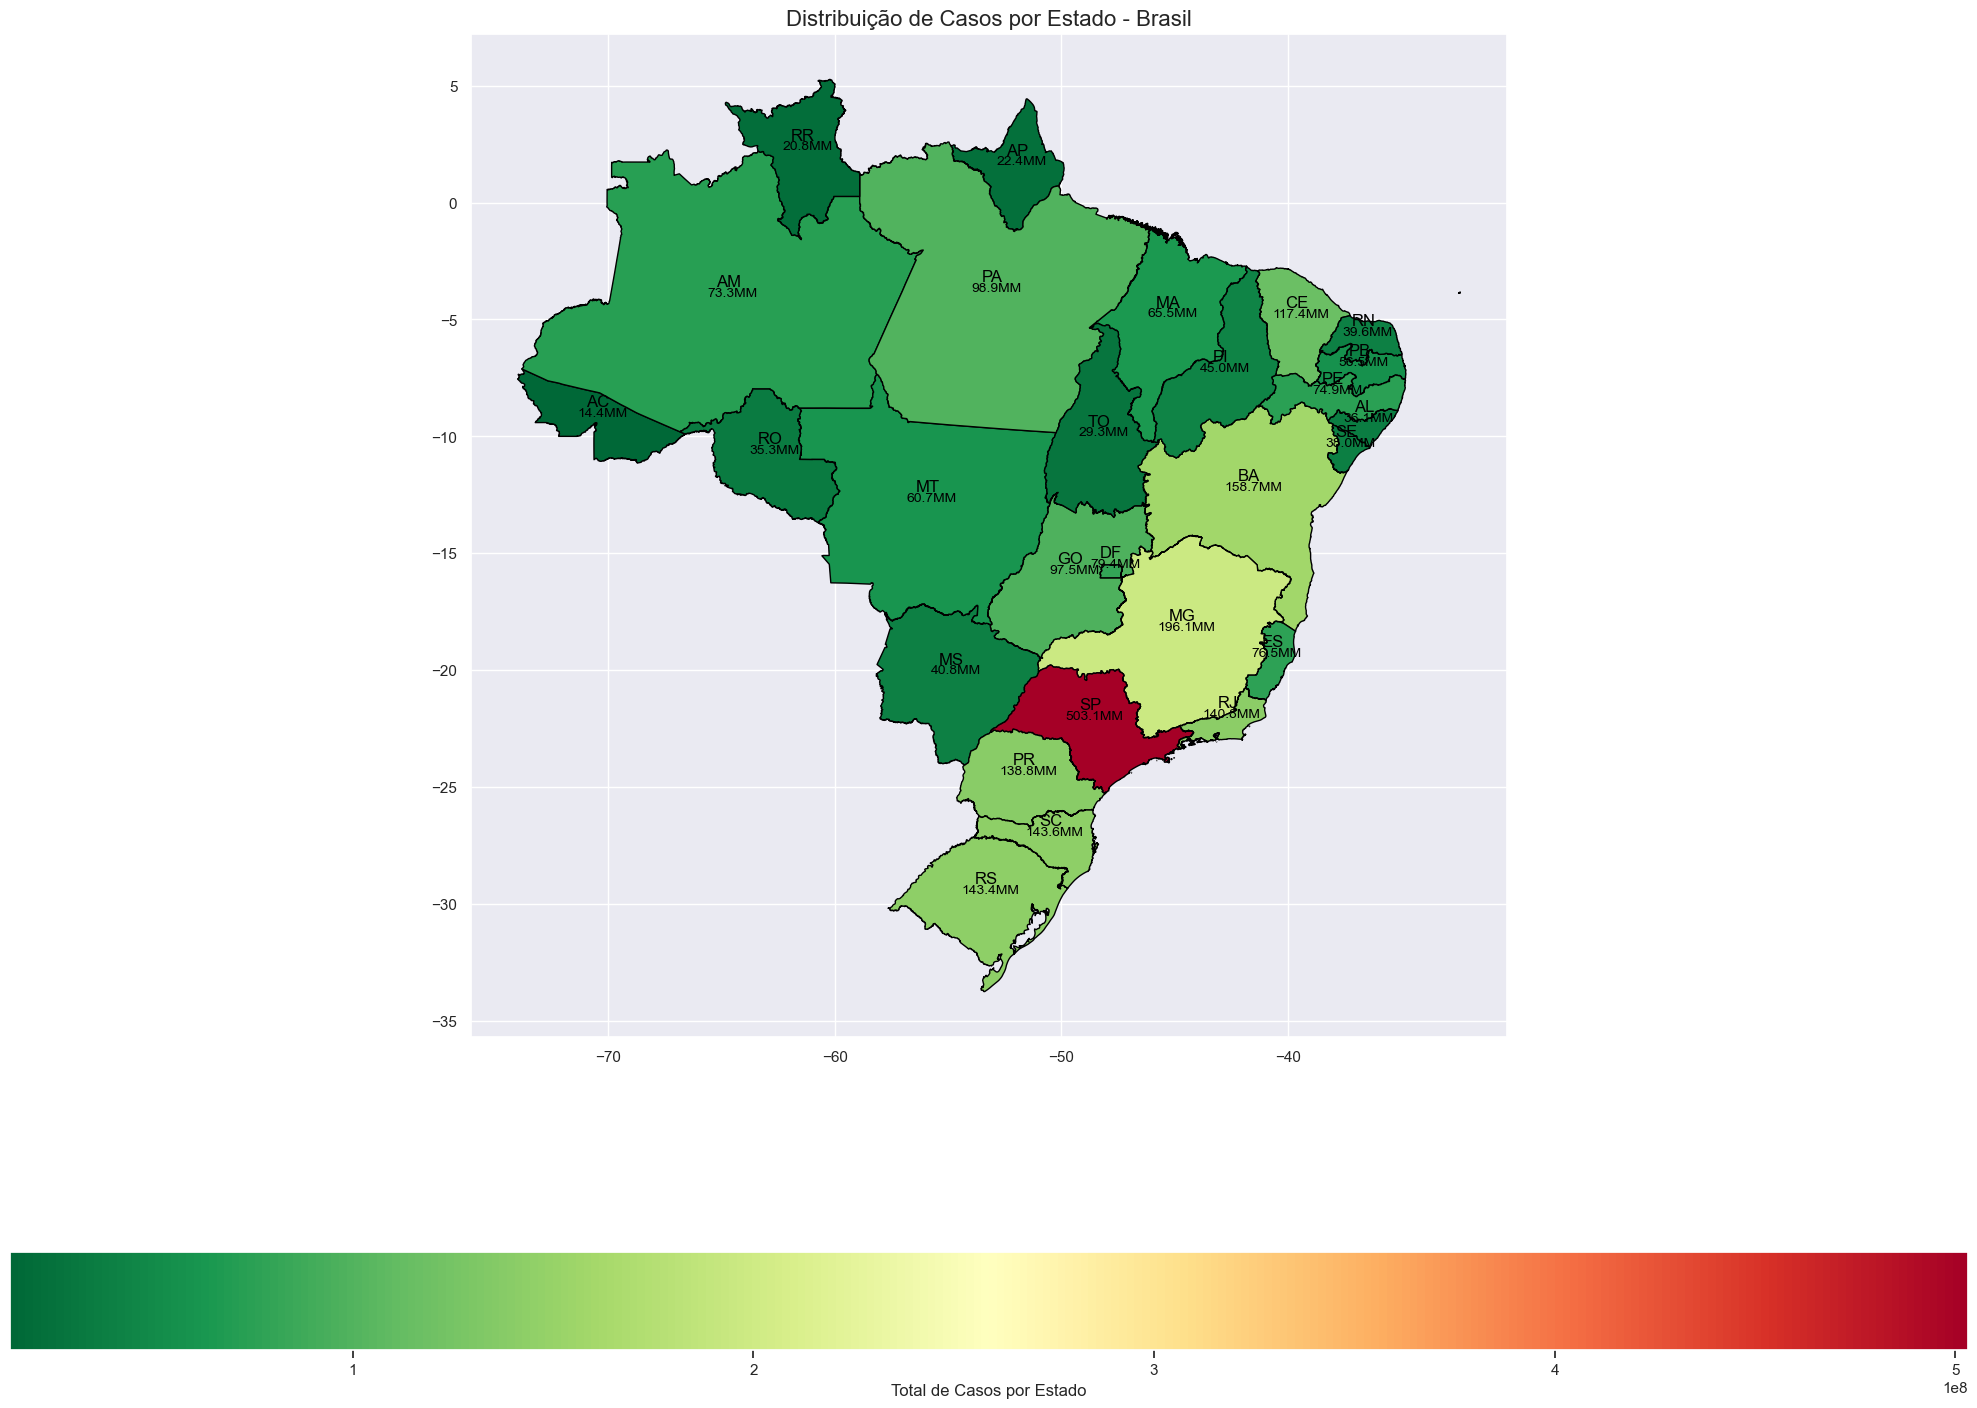

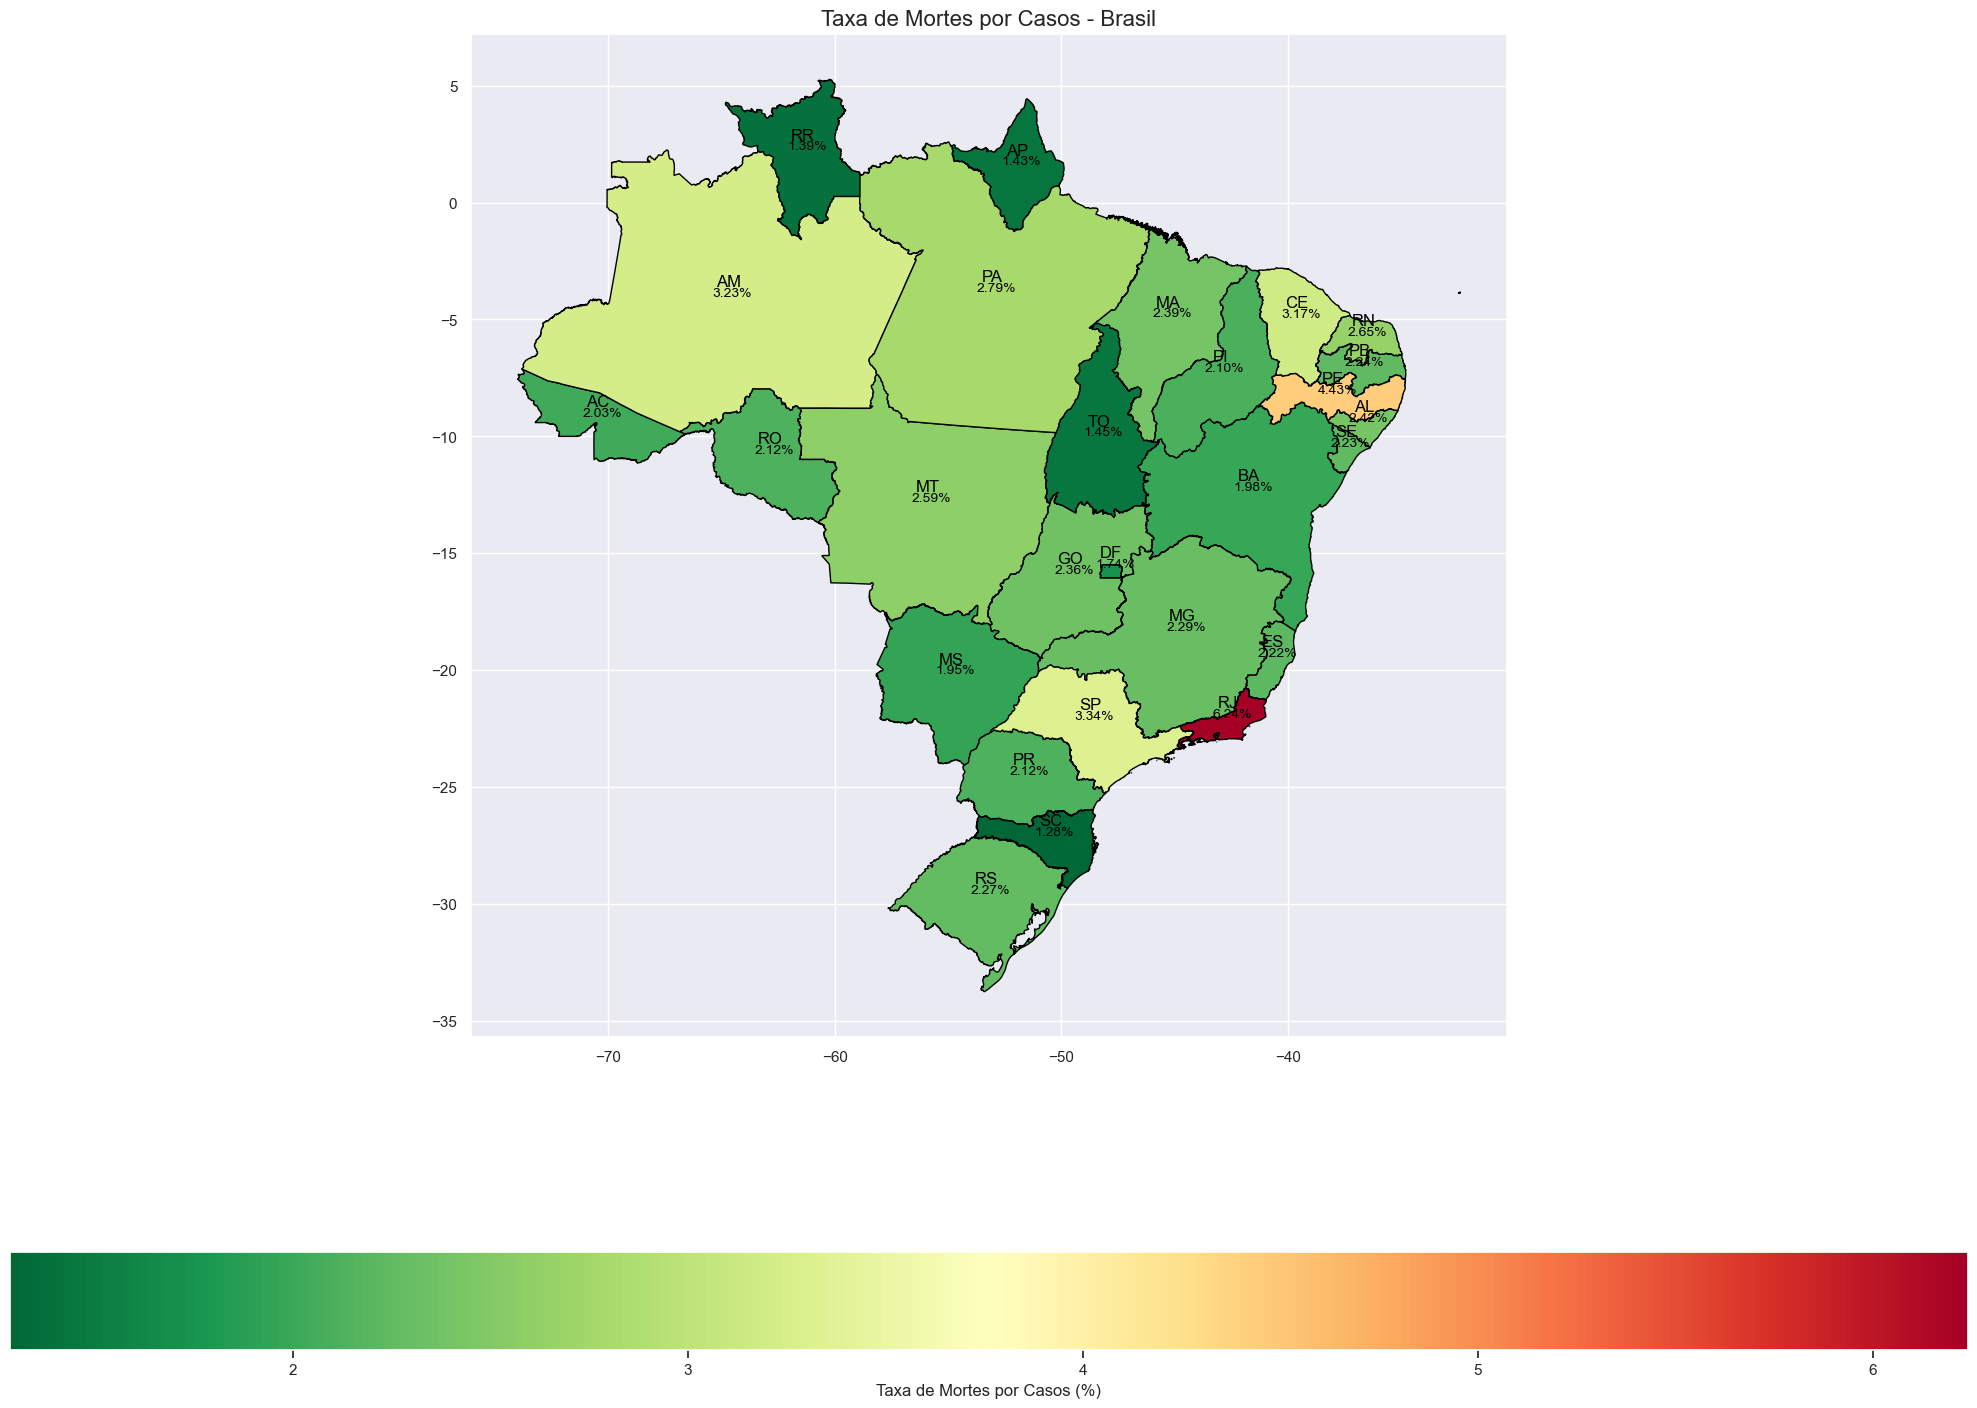

In [47]:
# Função para formatar os números
def format_number(n):
    if n >= 1_000_000:
        return f'{n / 1_000_000:.1f}MM'  # Para milhões (ex: 50.0MM)
    elif n >= 1_000:
        return f'{n / 1_000:.1f}K'  # Para milhares (ex: 50.0K)
    else:
        return str(n)  # Para valores menores que 1.000

# Carregando o mapa do Brasil com Geopandas
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf = gpd.read_file(url)

# Unindo os dados de casos com os dados de geolocalização dos estados
gdf = gdf.set_index('sigla').join(df_cases_states_cross_section.set_index('state'))

# Plotando o mapa
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plotando o mapa com cores que variam de verde (menos casos) a vermelho (mais casos)
gdf.plot(column='cases', ax=ax, legend=True,
         legend_kwds={'label': "Total de Casos por Estado",
                      'orientation': "horizontal"},
         cmap='RdYlGn_r', edgecolor='black')

# Adicionando o número de casos em cada estado
for idx, row in gdf.iterrows():
    # Obtendo o centroide de cada estado
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    
    # Formatando o número de casos
    formatted_cases = format_number(row['cases'])
    
    # Adicionando o número de casos no centroide do estado
    ax.annotate(f'{formatted_cases}', xy=(x, y), xytext=(3, 3), textcoords="offset points",
                fontsize=10, color='black', ha='center')

    # Adicionando a sigla do estado no centroide
    ax.annotate(f'{row.name}', xy=(x, y), xytext=(0, 10), textcoords="offset points",
                fontsize=12, color='black', ha='center')

# Adicionando o título
ax.set_title("Distribuição de Casos por Estado - Brasil", fontsize=16)

# Exibindo o mapa
plt.tight_layout()
plt.show()

# Carregando o mapa do Brasil com Geopandas
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf = gpd.read_file(url)

# Unindo os dados de taxas com os dados de geolocalização dos estados
gdf = gdf.set_index('sigla').join(df_cases_states_cross_section.set_index('state'))

# Plotando o mapa
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plotando o mapa com cores que variam de verde (menor taxa) a vermelho (maior taxa)
gdf.plot(column='tax_deaths_per_cases', ax=ax, legend=True,
         legend_kwds={'label': "Taxa de Mortes por Casos (%)",
                      'orientation': "horizontal"},
         cmap='RdYlGn_r', edgecolor='black')

# Adicionando a taxa de mortes por caso em cada estado
for idx, row in gdf.iterrows():
    # Obtendo o centroide de cada estado
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    
    # Formatando a taxa de mortes
    formatted_rate = f'{row["tax_deaths_per_cases"]:.2f}%'
    
    # Adicionando a taxa de mortes no centroide do estado
    ax.annotate(f'{formatted_rate}', xy=(x, y), xytext=(3, 3), textcoords="offset points",
                fontsize=10, color='black', ha='center')

    # Adicionando a sigla do estado no centroide
    ax.annotate(f'{row.name}', xy=(x, y), xytext=(0, 10), textcoords="offset points",
                fontsize=12, color='black', ha='center')

# Adicionando o título
ax.set_title("Taxa de Mortes por Casos - Brasil", fontsize=16)

# Exibindo o mapa
plt.tight_layout()
plt.show()

# <font color='green' style='font-size: 30px;'> 2.2) Distribuição Acumulada </font>
<hr style='border: 2px solid green;'>

In [ ]:
# Agrupa por data e calcula a soma acumulada
df_grouped = df_cases_states.sort_values(by='date').groupby('date')[['cases', 'deaths']].sum().cumsum().reset_index()

print(df_grouped.head())  # Exibe os primeiros valores acumulados


         date  cases  deaths
0  2020-03-27      0       0
1  2020-03-28   3843     112
2  2020-03-29   8047     246
3  2020-03-30  12564     403
4  2020-03-31  18174     602


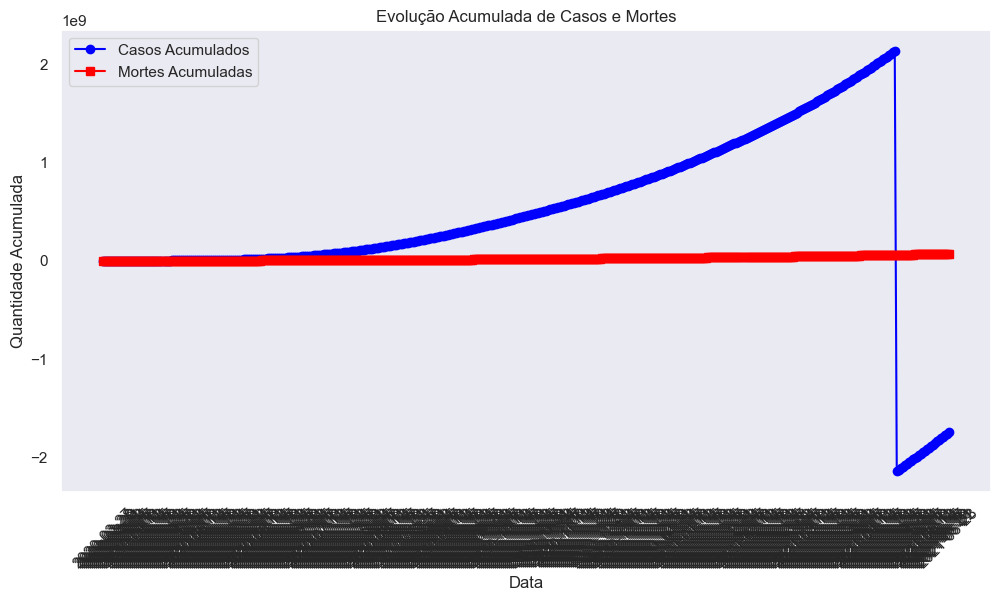

In [ ]:
# Criando o gráfico
plt.figure(figsize=(12,6))
plt.plot(df_grouped['date'], df_grouped['cases'], label='Casos Acumulados', color='blue', linestyle='-', marker='o')
plt.plot(df_grouped['date'], df_grouped['deaths'], label='Mortes Acumuladas', color='red', linestyle='-', marker='s')

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Quantidade Acumulada')
plt.title('Evolução Acumulada de Casos e Mortes')
plt.xticks(rotation=45)  # Rotaciona as datas para melhor visualização
plt.legend()
plt.grid()

# Exibir gráfico
plt.show()


# <font color='green' style='font-size: 30px;'> 2.3) Distribuição ao Longo do Tempo </font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 30px;'> 2.4) Mapa do Brasil com a Taxa de Casos/População e Taxa de Mortes/População </font>
<hr style='border: 2px solid green;'>

In [ ]:
# df_raw_groupped = df_raw.groupby(['Date', 'Country/Region']).agg({
#     "Lat": "max", 
#     "Long": "max", 
#     "Confirmed": "sum", 
#     "Recovered": "sum", 
#     "Deaths": "sum"
# }).reset_index()

In [ ]:
# plt.figure(figsize=(16,8))
# ax = plt.subplot(1,2,1)
# ax.set_title('Casos Acumulados', fontsize=18, loc='left')
# plt.plot(df_brazil['Brazil'], label='Brazil')
# plt.plot(df_conf_w['Argentina'], label='Argentina')
# plt.plot(df_conf_w['Uruguay'], label='Uruguay')
# plt.xlabel("Dia")
# plt.ylabel("Casos")
# plt.legend();
# ax = plt.subplot(1,2,2)
# ax.set_title('Óbitos Acumulados', fontsize=18, loc='left')
# plt.plot(df_brazil['Brazil'], label='Brazil')
# plt.plot(df_deaths_w['Argentina'], label='Argentina')
# plt.plot(df_deaths_w['Uruguay'], label='Uruguay')
# plt.xlabel("Dia")
# plt.ylabel("Óbitos")
# plt.legend()